# Quora Question Pairs
 Identifying questions on quora with same intent

## Problem Statement
 Where else but Quora can a physicist help a chef with a math problem and get cooking tips in return? Quora is a place to gain and share knowledge—about anything.
 It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.
 Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions.
 Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question.
 Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
 Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not.
 Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

 Data is taken from kaggle competition (2017) : https://kaggle.com/competitions/quora-question-pairs

## Dataset Description
 The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning.
 The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty.
 Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling.
 We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.
 Please note: as an anti-cheating measure, Kaggle has supplemented the test set with computer-generated question pairs. Those rows do not come from Quora, and are not counted in the scoring.
 All of the questions in the training set are genuine examples from Quora.

## Data Details
 1. id - the id of a training set question pair
 2. qid1, qid2 - unique ids of each question (only available in train.csv)
 3. question1, question2 - the full text of each question
 4. is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

## Businesss Constraints and Objectives
 1. Missclassification should be reduced.
 2. No Strict Low Latency requirements.
 3. Adaptable threshold for probability of classification.

## How this is a ML problem ?
 The objective is to classify whether two given questions are having same intention, typical classification problem.
 Create a application that takes two questions as input and in return tells if the questions have same meaning or not.

## Performance Metric
 Metric(s):
 Log-Loss and Binary Confusion Matrix

## Importing Needed Libraries and accessing other py files(feature-extraction).

In [1]:
import os 
import sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
# from feature_extraction import process_data, extract_features
from feature_extraction import process_and_extract_features
from ml_algorithms.tSNE_for_data_visualization import plot_tsne_visualization
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Importing other files from ml_algorithms folder:

import sys
sys.path.append(os.getcwd()+'\ml_algorithms')

In [3]:
from Logistic_Regression import logistic_regression_function
from SGDClassfier_RandomSearch_V1 import sgd_random_search_v1
from NaiveBayes import naive_bayes_function
from XGBoost_Random_Search import xgboost_random_search
# # Getting the current script's directory
# current_dir = os.path.dirname(os.path.abspath(__file__))

# # Adding the parent directory to the Python path
# sys.path.append(os.path.dirname(current_dir))

# # Import other python files.
#

## Load the Data and Perform Data Analysis

In [4]:
data = pd.read_csv('data/train.csv')

 First 5 rows of data

In [5]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
print(f"Number of Observations in data are {data.shape[0]}")

Number of Observations in data are 404290


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
None


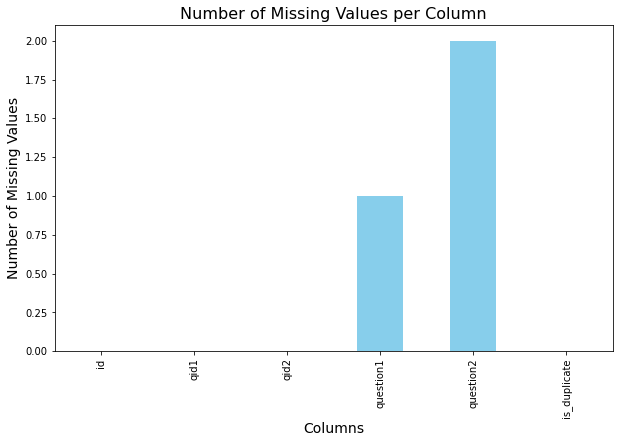

In [7]:
print(data.info())

missing_values_count = data.isnull().sum()

# Create a bar plot of missing values
plt.figure(figsize=(10, 6))
missing_values_count.plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Number of Missing Values per Column', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Number of Missing Values', fontsize=14)

# Show the plot
plt.show()

 Note: There are two null values in question 2 and one null value in question 1, dropping those rows.

In [8]:
# Count the number of rows before dropping
rows_before_drop = len(data)

# Drop rows with missing values
data = data.dropna()

# Count the number of rows after dropping
rows_after_drop = len(data)

# Calculate the number of rows dropped
rows_dropped = rows_before_drop - rows_after_drop

# Display the number of rows dropped
print("Number of rows dropped:", rows_dropped)

Number of rows dropped: 3


## Distribution of data points among output classes (Similar and Non Similar Questions)
 Check for Balance of Data (Ouput Column: is_duplicate)

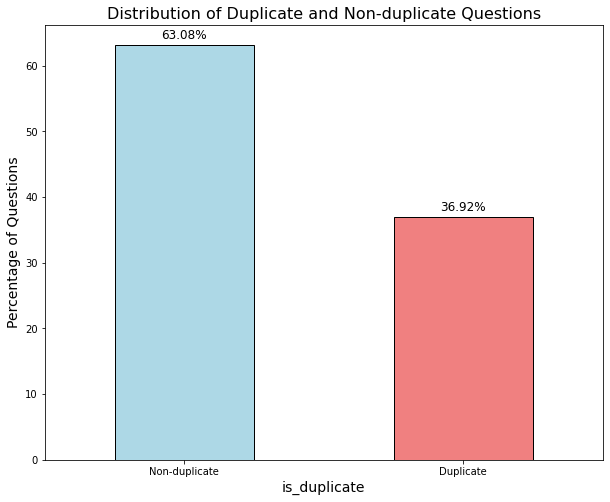

In [9]:
# Group by 'is_duplicate' and count the number of observations for each group
grouped_data = data.groupby("is_duplicate")['id'].count()

total_questions = grouped_data.sum()
percentages = (grouped_data / total_questions) * 100

colors = ['lightblue', 'lightcoral']  
plt.figure(figsize=(10, 8))  
ax = percentages.plot(kind='bar', color=colors, edgecolor='black')

plt.title('Distribution of Duplicate and Non-duplicate Questions', fontsize=16)
plt.xlabel('is_duplicate', fontsize=14)
plt.ylabel('Percentage of Questions', fontsize=14)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

ax.set_xticklabels(['Non-duplicate', 'Duplicate'], rotation=0)

plt.show()

 Number of Unique Questions, Number of Unique Question appearing more than one time and number of times a single question is repeated.

In [10]:
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print('Total number of Unique Questions: {}\n'.format(unique_qs))
print('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime, round(qs_morethan_onetime/unique_qs*100,2)))
print('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

Total number of Unique Questions: 537929

Number of unique questions that appear more than one time: 111778 (20.78%)

Max number of times a single question is repeated: 157



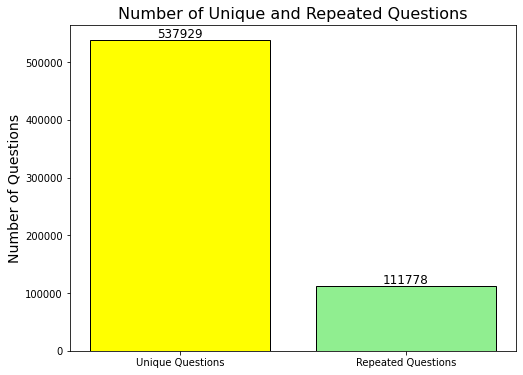

In [11]:
# Plot the number of unique questions and repeated questions
plt.figure(figsize=(8, 6))
colors = ['yellow', 'lightgreen']
plt.bar(['Unique Questions', 'Repeated Questions'], [unique_qs, qs_morethan_onetime], color=colors, edgecolor='black')

plt.title('Number of Unique and Repeated Questions', fontsize=16)
plt.ylabel('Number of Questions', fontsize=14)

# Add text annotations
for i, count in enumerate([unique_qs, qs_morethan_onetime]):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=12)

plt.show()

 Checking for Duplicates

In [12]:
# Check for rows where qid1 and qid2 are the same
same_qid_rows = data[data['qid1'] == data['qid2']]

# Check for rows where qid1 and qid2 are interchanged
interchanged_qid_rows = data[data.apply(lambda row: row['qid1'] == row['qid2'] or (row['qid1'] == row['qid2'] and row['qid1'] is not None and row['qid2'] is not None), axis=1)]

# Display the results
print("Rows where qid1 and qid2 are the same:")
print(same_qid_rows)

print("\nRows where qid1 and qid2 are interchanged:")
print(interchanged_qid_rows)

# Count the total number of duplicate pairs
total_duplicates = len(same_qid_rows) + len(interchanged_qid_rows)
print("Total number of duplicate pairs:", total_duplicates)

Rows where qid1 and qid2 are the same:
Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

Rows where qid1 and qid2 are interchanged:
Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []
Total number of duplicate pairs: 0


 Number of Occurances of each question.

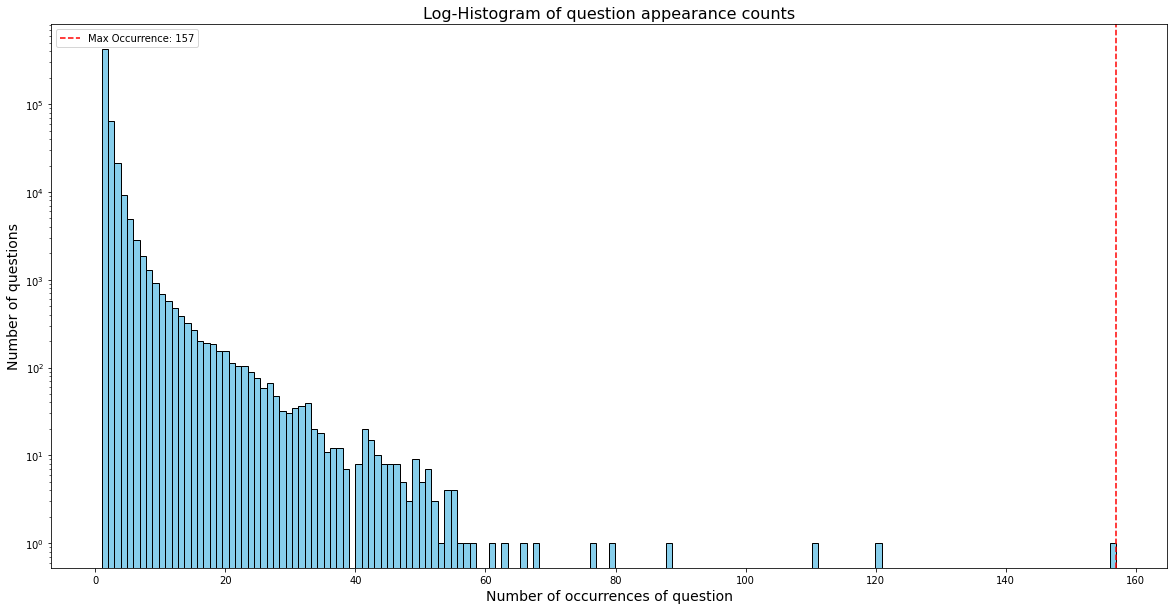

In [13]:
plt.figure(figsize=(20, 10))

counts, bins, _ = plt.hist(qids.value_counts(), bins=160, color='skyblue', edgecolor='black')

plt.yscale('log', nonpositive='clip')

plt.title('Log-Histogram of question appearance counts', fontsize=16)
plt.xlabel('Number of occurrences of question', fontsize=14)
plt.ylabel('Number of questions', fontsize=14)

max_occurrence = max(qids.value_counts())
plt.axvline(x=max_occurrence, color='red', linestyle='--', label=f'Max Occurrence: {max_occurrence}')

plt.legend()

plt.show()

 The plot is close to a power-law distribution not exactly power-law but close to it.

### Top 10 Most asked questions on Quora:

In [14]:
all_questions = pd.concat([data['question1'], data['question2']], ignore_index=True)

# Display the top 10 most common questions
top_10_common_questions = all_questions.value_counts().head(10)

print("Top 10 Most Common Questions:")
print(top_10_common_questions)

Top 10 Most Common Questions:
What are the best ways to lose weight?                                                                161
How can you look at someone's private Instagram account without following them?                       120
How can I lose weight quickly?                                                                        111
What's the easiest way to make money online?                                                           88
Can you see who views your Instagram?                                                                  79
What are some things new employees should know going into their first day at AT&T?                     77
What do you think of the decision by the Indian Government to demonetize 500 and 1000 rupee notes?     68
Which is the best digital marketing course?                                                            66
How can you increase your height?                                                                      63
How do l see who

### Distribution of Question Lengths:

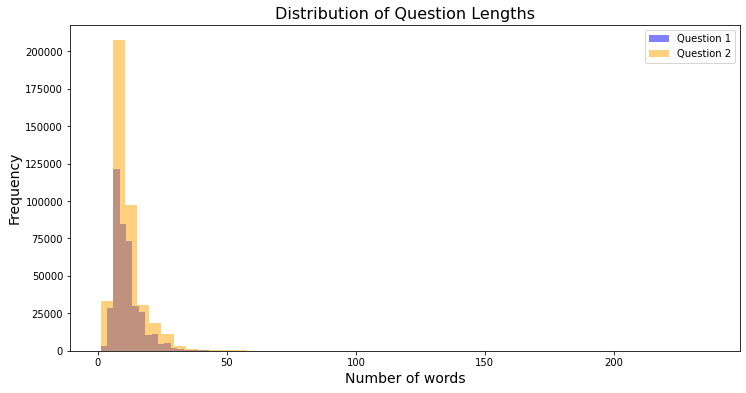

In [15]:
# Function to count the number of words in a sentence
def count_words(sentence):
    # Handle the case where the sentence is NaN (missing value)
    if pd.isnull(sentence):
        return 0
    # Count the number of words by splitting the sentence
    return len(str(sentence).split())

# Plot histograms for question lengths
plt.figure(figsize=(12, 6))
plt.hist(data['question1'].apply(lambda x: count_words(x)), bins=50, alpha=0.5, label='Question 1', color='blue')
plt.hist(data['question2'].apply(lambda x: count_words(x)), bins=50, alpha=0.5, label='Question 2', color='orange')

# Title and labels
plt.title('Distribution of Question Lengths', fontsize=16)
plt.xlabel('Number of words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display legend
plt.legend()

plt.show()

 References for feature extraction:
 - Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
 - Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
 - Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

## Feature Extraction
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2

## Pre-processing of Text

 - Preprocessing:
 1. Removing html tags
 2. Removing Punctuations
 3. Performing stemming
 4. Removing Stopwords
 5. Expanding contractions etc.

### Feature Extraction after pre-processing.
 Featurization (NLP and Fuzzy Features)
 Definition:
 - __Token__: You get a token by splitting sentence a space
 - __Stop_Word__ : stop words as per NLTK.
 - __Word__ : A token that is not a stop_word
 <br>
 <br>
 __Features__:
 - __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
 <br>
 <br>
 - __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
 <br>
 <br>
 - __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
 <br>
 <br>
 - __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
 <br>
 <br>
 - __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
 <br>
 <br>
 - __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
 <br>
 <br>
 - __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
 <br>
 <br>
 - __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
 <br>
 <br>
 - __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
 <br>
 <br>
 - __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
 <br>
 <br>
 - __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
 http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
 <br>
 <br>
 - __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
 http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
 <br>
 <br>
 - __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
 http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
 <br>
 <br>
 - __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
 http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
 <br>
 <br>
 - __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens)) <br>
## Some additional features - Adding some more features which I feel will add good information. <br>
 ratio_q_lengths:  This feature calculates the ratio of the lengths of the two questions. <br>
 common_prefix: This feature computes the length of the common prefix (the initial common sequence of characters) between the two questions. <br>
 common_suffix: This feature calculates the length of the common suffix (the final common sequence of characters) between the two questions. <br>
 diff_words: This feature calculates the absolute difference in the number of words between the two questions. <br>
 diff_chars: This feature computes the absolute difference in the number of characters between the two questions. <br>
 jaccard_similarity: This feature calculates the Jaccard similarity coefficient between the sets of words in the two questions. <br>
 longest_common_subsequence: This feature computes the length of the longest common subsequence (LCS) between the two questions. <br>

## Processing and Extracting Features

In [16]:
# Processing and Extracting Features
file_path = "data_with_features.csv"

# *****************************************************Observations_to_Train*************************************************
rows_to_train = 100000 # Change as per Needs
print(f"TRAINING WITH {rows_to_train} OBSERVATIONS")
# ***************************************************************************************************************************

if os.path.isfile(file_path):
    data = pd.read_csv(file_path, encoding='latin-1')
    data.fillna('', inplace=True)  # Fill NaN values with empty string if needed
else:
    data = process_and_extract_features(file_path,rows_to_train)

TRAINING WITH 100000 OBSERVATIONS


In [17]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,ratio_q_lengths,common_prefix,common_suffix,diff_words,diff_chars,jaccard_similarity,longest_common_subsequence
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,93,100,0.982759,1.157895,57,1,2,9,0.916667,57
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,1,51,88,...,66,75,0.596154,0.579545,5,1,5,37,0.411765,46
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,54,54,0.166667,1.237288,9,1,4,14,0.200000,36
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,35,40,0.039216,0.769231,0,1,2,15,0.000000,21
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,1,1,76,39,...,46,56,0.175000,1.948718,6,1,6,37,0.250000,27


### Check for questions with 2 words or less than 2 words

In [18]:
# Filter sentences with 2 words or less in either q1 or q2
filtered_data = data[(data['q1_n_words'] <= 2) | (data['q2_n_words'] <= 2)]

# Print the filtered sentences along with is_duplicate column and the number of sentences
num_sentences = len(filtered_data)
print(f"Number of Sentences: {num_sentences}\n")

for index, row in filtered_data.head(10).iterrows():
    print(f"Q1: {row['question1']}")
    print(f"Q2: {row['question2']}")
    print(f"Is Duplicate: {row['is_duplicate']}")
    print("-" * 50)

Number of Sentences: 2

Q1: 
Q2: why is cornell own endowment the lowest in the ivy league 
Is Duplicate: 0
--------------------------------------------------
Q1: cloud certification 
Q2: how do you show whether 2 n 5 n 2  n 1   5  n 1  is divisiblev by 3 
Is Duplicate: 0
--------------------------------------------------


In [19]:
print ("Minimum length of the questions in question1 : " , min(data['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(data['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", data[data['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", data[data['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  3
Number of Questions with minimum length [question1] : 1
Number of Questions with minimum length [question2] : 0
 1
Number of Questions with minimum length [question2] : 0


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Function to calculate KL Divergence
def calculate_kl_divergence(duplicate_data, non_duplicate_data, feature):
    duplicate_dist = duplicate_data[feature].dropna()
    non_duplicate_dist = non_duplicate_data[feature].dropna()

    epsilon = 1e-10
    duplicate_dist += epsilon
    non_duplicate_dist += epsilon

    min_length = min(len(duplicate_dist), len(non_duplicate_dist))
    duplicate_dist = duplicate_dist.head(min_length)
    non_duplicate_dist = non_duplicate_dist.head(min_length)

    kl_divergence = entropy(duplicate_dist, non_duplicate_dist)
    return kl_divergence

features_to_plot = ['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
                    'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
                    'ratio_q_lengths', 'common_prefix', 'common_suffix', 'diff_words', 'diff_chars',
                    'jaccard_similarity', 'longest_common_subsequence', 'cwc_min', 'cwc_max', 'csc_min',
                    'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
                    'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
                    'longest_substr_ratio']

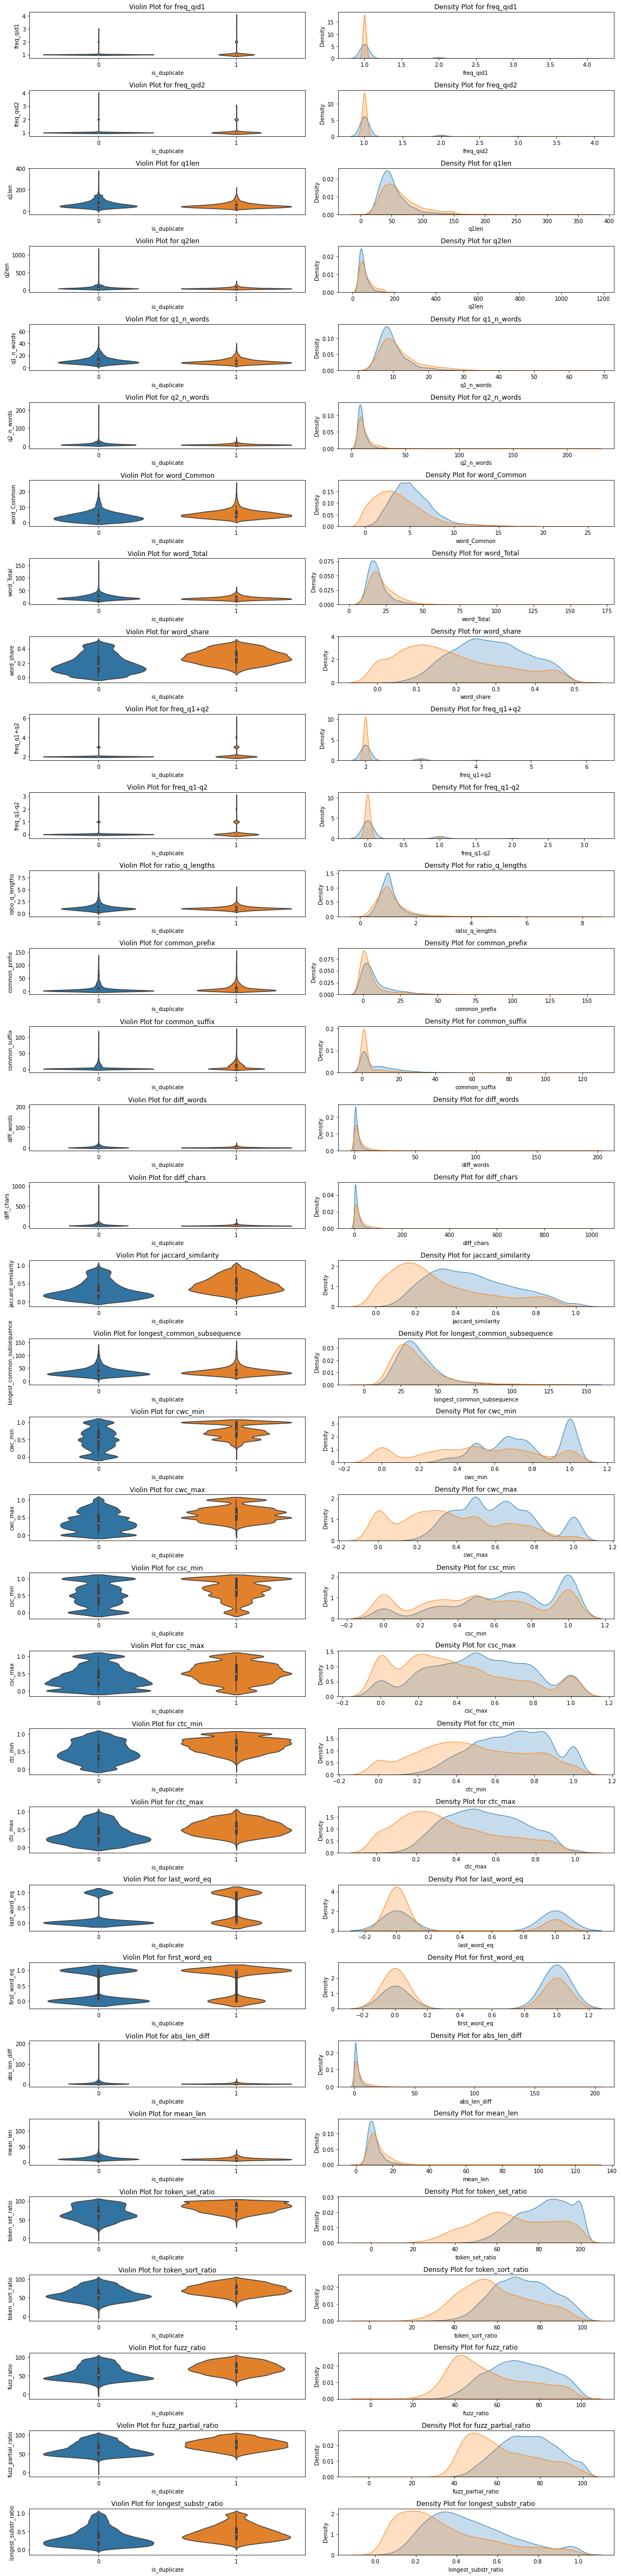

In [21]:
# Create one image with Violin plots and Density plots for each feature
num_features = len(features_to_plot)
plt.figure(figsize=(16, 2*num_features))

for i, feature in enumerate(features_to_plot):
    plt.subplot(num_features, 2, 2*i + 1)
    sns.violinplot(x='is_duplicate', y=feature, data=data)
    plt.title(f'Violin Plot for {feature}')

    plt.subplot(num_features, 2, 2*i + 2)
    sns.kdeplot(data[data['is_duplicate'] == 1][feature], label='Duplicate', shade=True)
    sns.kdeplot(data[data['is_duplicate'] == 0][feature], label='Not Duplicate', shade=True)
    plt.title(f'Density Plot for {feature}')

plt.tight_layout()
plt.show()

                       Feature  KL_Divergence
0                    freq_qid1       0.037428
1                    freq_qid2       0.039454
2                        q1len       0.200993
3                        q2len       0.227948
4                   q1_n_words       0.192472
5                   q2_n_words       0.217863
6                  word_Common       2.240836
7                   word_Total       0.137293
8                   word_share       1.894844
9                   freq_q1+q2       0.023029
10                  freq_q1-q2      21.018983
11             ratio_q_lengths       0.184829
12               common_prefix      12.647388
13               common_suffix       1.654155
14                  diff_words       4.191871
15                  diff_chars       1.772214
16          jaccard_similarity       1.544315
17  longest_common_subsequence       0.184226
18                     cwc_min       3.533606
19                     cwc_max       3.514450
20                     csc_min    

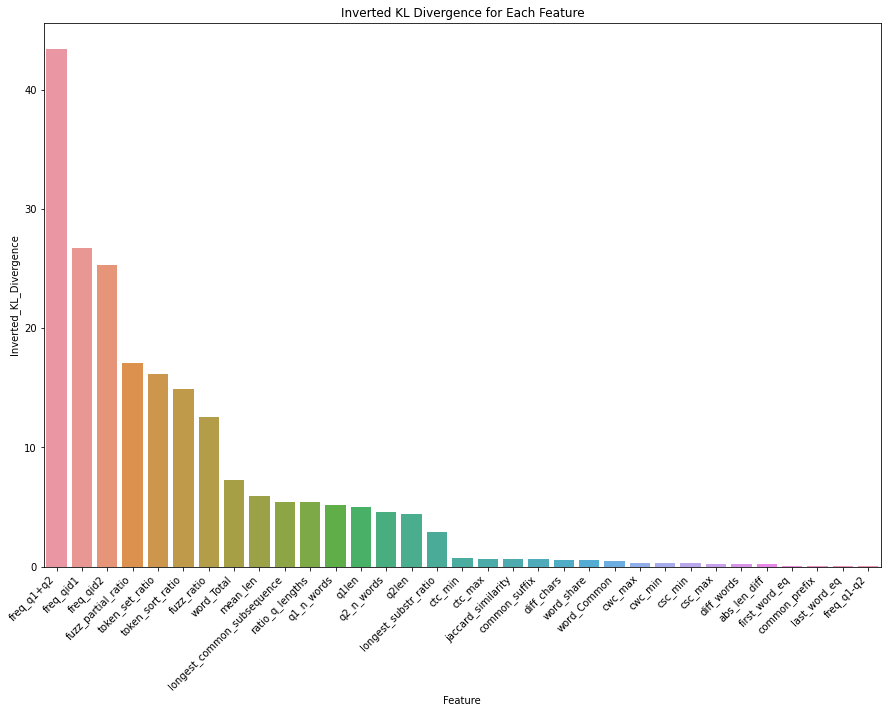

In [22]:
# Calculate and visualize inverted KL Divergence
kl_divergence_results = pd.DataFrame(columns=['Feature', 'KL_Divergence'])

for feature in features_to_plot:
    kl_divergence = calculate_kl_divergence(data[data['is_duplicate'] == 1], data[data['is_duplicate'] == 0], feature)
    kl_divergence_results = pd.concat([kl_divergence_results, pd.DataFrame({
        'Feature': [feature],
        'KL_Divergence': [kl_divergence]
    })], ignore_index=True)

# Display KL Divergence results in a table
print(kl_divergence_results)

# Create a bar plot to visualize inverted KL Divergence
kl_divergence_results['Inverted_KL_Divergence'] = 1 / (kl_divergence_results['KL_Divergence'] + 1e-10)

plt.figure(figsize=(15, 10))
sns.barplot(x='Feature', y='Inverted_KL_Divergence', data=kl_divergence_results.sort_values(by='Inverted_KL_Divergence', ascending=False))
plt.title('Inverted KL Divergence for Each Feature')
plt.xticks(rotation=45, ha='right')
plt.show()

The best 5 features are:
9             freq_q1+q2
0              freq_qid1
1              freq_qid2
31    fuzz_partial_ratio
28       token_set_ratio
Name: Feature, dtype: object


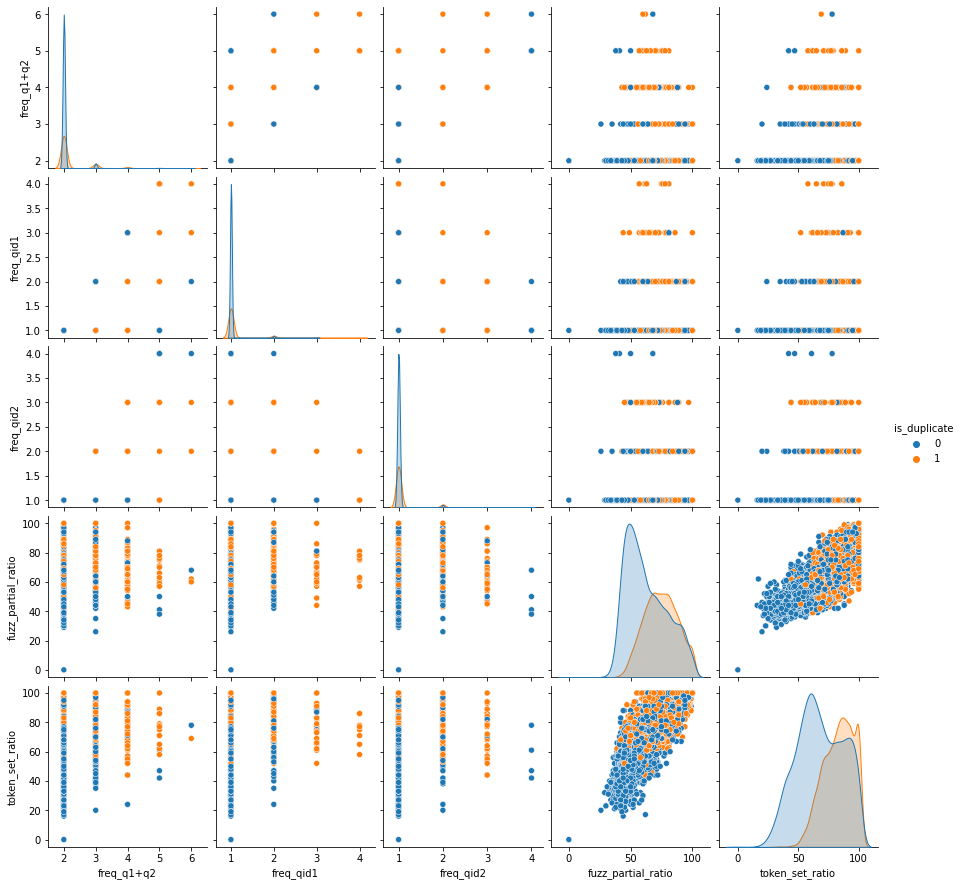

In [23]:
bottom_5_features = kl_divergence_results.nsmallest(5, 'KL_Divergence')['Feature']

print("The best 5 features are:")
print(bottom_5_features)

# Pair plot for the top 10 features
n = data.shape[0]
sns.pairplot(data[bottom_5_features.tolist() + ['is_duplicate']][0:n], hue='is_duplicate', vars=bottom_5_features.tolist())
plt.show()

### Important features in differentiating Duplicate(Similar) and Non-Duplicate(Dissimilar) Questions.
 1. Distribution of q1len for Duplicate and Non-duplicate Questions overlap but not completely making it a good feature.
 2. Distribution of q2len for Duplicate and Non-duplicate Questions overlap but not completely making it a good feature.
 3. Distribution of q1_n_words for Duplicate and Non-duplicate Questions overlap but not completely making it a good feature.
 4. Distribution of q2_n_words for Duplicate and Non-duplicate Questions overlap but not completely making it a good feature.
 5. Distribution of word_Total for Duplicate and Non-duplicate Questions overlap but not completely making it a good feature.
 6. Distribution of word_share for Duplicate and Non-duplicate Questions overlap but not completely making it a good feature.

## Visualizing in lower dimension using t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.010s...
[t-SNE] Computed neighbors for 5000 samples in 0.278s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.119s
[t-SNE] Iteration 50: error = 85.3974533, gradient norm = 0.0937160 (50 iterations in 0.804s)
[t-SNE] Iteration 100: error = 70.7411041, gradient norm = 0.0138564 (50 iterations in 0.694s)
[t-SNE] Iteration 150: error = 68.6932983, gradient norm = 0.0077781 (50 iterations in 0.686s)
[t-SNE] Iteration 200: error = 67.7471161, gradient norm = 0.0056287 (50 iterations in 0.733s)
[t-SNE] Iteration 250: error = 67.2232513, gradient norm = 0.0043651

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



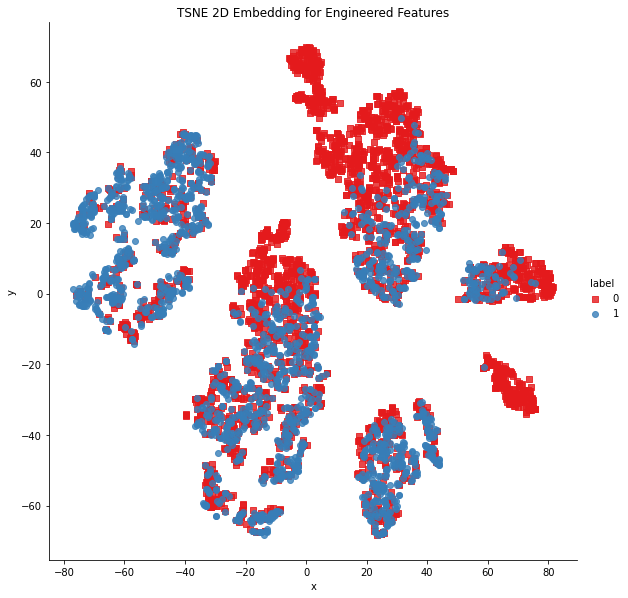

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 0.279s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.128s
[t-SNE] Iteration 50: error = 86.3209305, gradient norm = 0.0843951 (50 iterations in 1.785s)
[t-SNE] Iteration 100: error = 69.4750214, gradient norm = 0.0074308 (50 iterations in 1.430s)
[t-SNE] Iteration 150: error = 67.7563171, gradient norm = 0.0037761 (50 iterations in 1.314s)
[t-SNE] Iteration 200: error = 67.1384430, gradient norm = 0.0025440 (50 iterations in 1.309s)
[t-SNE] Iteration 250: error = 66.7959747, gradient norm = 0.0018850

In [24]:
plot_tsne_visualization(data)

## Featurizing text data with Tf-Idf weighted word-vectors

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy
from spacy.cli import download

# Load the dataset
df = pd.read_csv('data/train.csv')

# change this for final training of model
# ***************************************Observations_to_Train***************************************************************
df = df[:rows_to_train]
# ***************************************************************************************************************************
# Encode questions to unicode
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

# Combine texts
questions = list(df['question1']) + list(df['question2'])

# TF-IDF vectorization
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

def load_spacy_model(model_name='en_core_web_lg'):
    try:
        # Check if the spaCy model is already installed
        nlp = spacy.load(model_name)
        print(f"spaCy model '{model_name}' loaded successfully.")
    except OSError:
        print(f"Model '{model_name}' not found. Downloading...")
        # Download the spaCy model if not already installed
        download(model_name)
        nlp = spacy.load(model_name)
        print(f"spaCy model '{model_name}' downloaded and loaded successfully.")

    return nlp

# Load spaCy model
nlp = load_spacy_model()

# Extract features using spaCy
vecs1 = []
vecs2 = []

for qu1, qu2 in tqdm(zip(list(df['question1']), list(df['question2']))):
    doc1 = nlp(qu1)
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])

    for word1 in doc1:
        vec1 = word1.vector
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        mean_vec1 += vec1 * idf

    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])

    for word2 in doc2:
        vec2 = word2.vector
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        mean_vec2 += vec2 * idf

    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)

df['q1_feats_m'] = list(vecs1)
df['q2_feats_m'] = list(vecs2)

15it [00:00, 71.43it/s]

spaCy model 'en_core_web_lg' loaded successfully.


100000it [20:59, 79.41it/s]


In [26]:
# Loading Processing and Extracting Features data
if os.path.isfile('data_with_features.csv'):
    dfnlp = pd.read_csv("data_with_features.csv", encoding='latin-1', nrows = rows_to_train)
else:
    print("Run the Processing and Extracting Features Cell")

# Drop unnecessary columns
df1 = dfnlp.drop(['qid1', 'qid2', 'question1', 'question2'], axis=1)
df3 = df.drop(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index=df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index=df3.index)

# Display information about features
print("Number of features in nlp dataframe:", df1.shape[1])
print("Head(5) of nlp dataframe:")
print(df1.head(5))

print("\nNumber of features in question1 w2v dataframe:", df3_q1.shape[1])
print("Head(5) of question1 w2v dataframe:")
print(df3_q1.head(5))

print("\nNumber of features in question2 w2v dataframe:", df3_q2.shape[1])
print("Head(5) of question2 w2v dataframe:")
print(df3_q2.head(5))

print("\nNumber of features in the final dataframe:", df1.shape[1] + df3_q1.shape[1] + df3_q2.shape[1])

Number of features in nlp dataframe: 35
Head(5) of nlp dataframe:
   id  is_duplicate  freq_qid1  freq_qid2  q1len  q2len  q1_n_words  \
0   0             0          1          1     66     57          14   
1   1             0          1          1     51     88           8   
2   2             0          1          1     73     59          14   
3   3             0          1          1     50     65          11   
4   4             0          1          1     76     39          13   

   q2_n_words  word_Common  word_Total  ...  fuzz_ratio  fuzz_partial_ratio  \
0          12         10.0        23.0  ...          93                 100   
1          13          4.0        20.0  ...          66                  75   
2          10          4.0        24.0  ...          54                  54   
3           9          0.0        19.0  ...          35                  40   
4           7          2.0        20.0  ...          46                  56   

   longest_substr_ratio  ratio_q

In [27]:
# Check if the final_features.csv file already exists
if not os.path.isfile('final_features.csv'):
    # Add id column to df3_q1 and df3_q2
    df3_q1['id'] = df1['id']
    df3_q2['id'] = df1['id']
    
    # Merge df1 with df3_q1 and df3_q2 on 'id'
    result = df1.merge(df3_q1, on='id', how='left').merge(df3_q2, on='id', how='left')
    
    # Save the result to final_features.csv
    result.to_csv('final_features.csv', index=False)

In [28]:
# Read the CSV file
df = pd.read_csv('final_features.csv')

In [29]:
# Replace non-numeric values with NaN
df.replace({col: {'_x': np.nan} for col in data.columns}, inplace=True)

# Check if there are any NA values in the DataFrame
if df.isna().any().any():
    print("NA Values Present")
else:
    print("No NA Values Present")

# Check the number of NaN values in each column after replacement
nan_counts = df.isna().sum()
print("Number of NaN values in each column after replacement:")
print(nan_counts)

No NA Values Present
Number of NaN values in each column after replacement:
id              0
is_duplicate    0
freq_qid1       0
freq_qid2       0
q1len           0
               ..
295_y           0
296_y           0
297_y           0
298_y           0
299_y           0
Length: 635, dtype: int64


In [30]:
# Remove the first row 
# df.drop(data.index[0], inplace=True)

# Get the target variable
y_true = df['is_duplicate']
df.drop(['id', 'is_duplicate'], axis=1, inplace=True)

print(df.shape)

# Convert all the features into numeric
cols = list(df.columns)
for i in cols:
    df[i] = pd.to_numeric(df[i], errors='coerce')

(10000, 633)


In [31]:
# Check for NA Values
if df.isna().any().any():
    print("NA Values Present")
else:
    print("No NA Values Present")
# Check the number of NaN values in each column after conversion
nan_counts_after_conversion = df.isna().sum()
print("Number of NaN values in each column after conversion:")
print(nan_counts_after_conversion)

# Convert y_true to a list of integers
y_true = list(map(int, y_true.values))

# Display the first few rows of the data
df.head()

No NA Values Present
Number of NaN values in each column after conversion:
freq_qid1     0
freq_qid2     0
q1len         0
q2len         0
q1_n_words    0
             ..
295_y         0
296_y         0
297_y         0
298_y         0
299_y         0
Length: 633, dtype: int64


,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,1,1,66,57,14,12,10.0,23.0,0.434783,2,...,-17.847826,7.261096,1.540010,-7.622686,0.257453,-11.788991,-11.277733,2.011430,3.519230,12.039696
1,1,1,51,88,8,13,4.0,20.0,0.200000,2,...,17.852024,4.326833,-3.825564,5.770448,29.321322,5.354765,-24.798782,10.162131,-3.104023,29.437483
2,1,1,73,59,14,10,4.0,24.0,0.166667,2,...,-23.582514,-1.179034,11.687271,8.937951,11.442068,1.628508,6.229581,0.037444,-12.051857,26.735333
3,1,1,50,65,11,9,0.0,19.0,0.000000,2,...,-5.243105,1.585634,-0.612667,-2.837080,-4.261224,-2.983107,-4.016992,-12.834697,4.316532,-6.966497
4,1,1,76,39,13,7,2.0,20.0,0.100000,2,...,-10.464317,-8.362595,-14.462657,-12.586632,-4.429658,12.575071,-11.845240,-16.343930,3.843574,-9.886225


## Splitting into Train and Test Data

In [32]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

# Convert lists to DataFrames if they are not already
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# Create a DataFrame to display the sizes of the splits
split_sizes = pd.DataFrame({
    'Data Split': ['X_train', 'X_test', 'y_train', 'y_test'],
    'Size': [X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]]
})

# Display the split sizes in tabular format
print("Size of Data Splits:")
print(split_sizes)

# Print head(5) for each split
print("Head of X_train:")
print(X_train.head())

print("\nHead of X_test:")
print(X_test.head())

print("\nHead of y_train:")
print(y_train.head())

print("\nHead of y_test:")
print(y_test.head())

Size of Data Splits:
  Data Split  Size
0    X_train  7000
1     X_test  3000
2    y_train  7000
3     y_test  3000
Head of X_train:
      freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  \
2476          1          1     35     77           6          15          4.0   
6619          2          1    150    125          32          21          9.0   
6299          2          1     39     35           7           7          5.0   
4813          1          1     53     45           8           7          4.0   
5679          1          1     66     63          14          14          5.0   

      word_Total  word_share  freq_q1+q2  ...      290_y      291_y  \
2476        21.0    0.190476           2  ...   4.419472   0.411826   
6619        46.0    0.195652           3  ... -43.424809  15.622628   
6299        14.0    0.357143           3  ...  -4.671723   4.911941   
4813        14.0    0.285714           2  ...  -9.440714  -2.305567   
5679        27.0    0.185

## Distribution of Output Variable in Train and Test Data

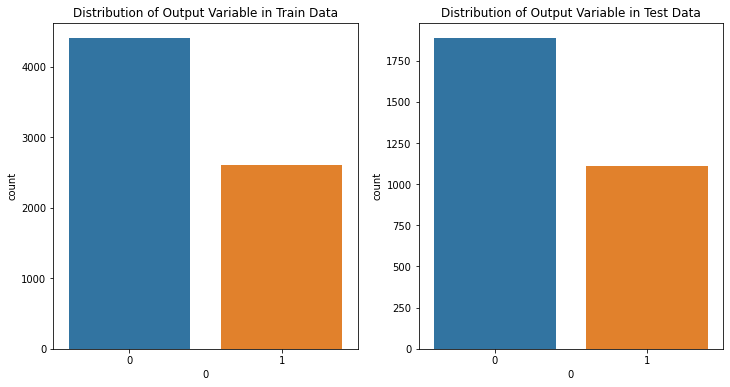

In [33]:
# Plotting the distribution of the output variable in train data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train.iloc[:, 0])
plt.title('Distribution of Output Variable in Train Data')

# Plotting the distribution of the output variable in test data
plt.subplot(1, 2, 2)
sns.countplot(x=y_test.iloc[:, 0])
plt.title('Distribution of Output Variable in Test Data')

plt.show()

## Using a Random Model to Predict and Noting Performance
 Our Models should perform better than the Random Model

In [34]:
from sklearn.metrics import log_loss

# Generate random predictions for y_train
np.random.seed(42)  # Set seed for reproducibility
random_predictions_train = np.random.rand(len(y_train))

# Ensure the predictions sum up to 1 for each sample
random_predictions_train /= random_predictions_train.sum(keepdims=True)

# Calculate log loss for y_train
log_loss_train = log_loss(y_train, random_predictions_train)

# Display the log loss for the training data
print(f'Log Loss for Training Data: {log_loss_train:.5f}')

# Generate random predictions for y_test
random_predictions_test = np.random.rand(len(y_test))
random_predictions_test /= random_predictions_test.sum(keepdims=True)

# Calculate log loss for y_test
log_loss_test = log_loss(y_test, random_predictions_test)

# Display the log loss for the test data
print(f'Log Loss for Test Data: {log_loss_test:.5f}')

Log Loss for Training Data: 3.39492
Log Loss for Test Data: 3.10965


## Logistic Regression ----> Baseline Model

Train Log Loss: 0.45294
Test Log Loss: 0.56616


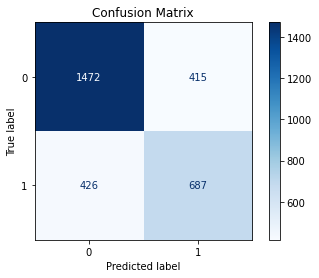

In [35]:
logistic_regression_function(X_train, X_test, y_train, y_test)

## SGDClassifier for predict </br>
 Performing hyperparameter tuning using RandomizedSearchCV for an SGDClassifier with elastic net penalty, followed by training, evaluation, and visualization of the best model. </br>
 The evaluation includes log loss calculation and display of the confusion matrix.

Best Parameters: {'method': 'sigmoid', 'base_estimator__penalty': 'elasticnet', 'base_estimator__loss': 'modified_huber', 'base_estimator__alpha': 0.1}
Train Log Loss: 0.49915
Test Log Loss: 0.53543


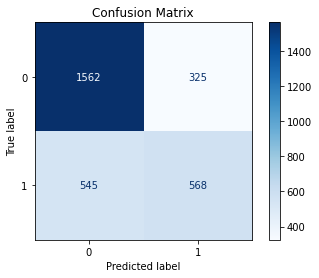

In [36]:
sgd_random_search_v1(X_train, X_test, y_train, y_test)

## NaiveBayesClassifier for prediction </br>

Train Log Loss: 11.62239
Test Log Loss: 11.34551


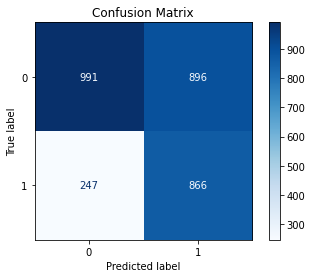

In [37]:
naive_bayes_function(X_train, X_test, y_train, y_test)

## XGBoost for prediction </br>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.5}
Train Log Loss: 0.28020
Test Log Loss: 0.45041


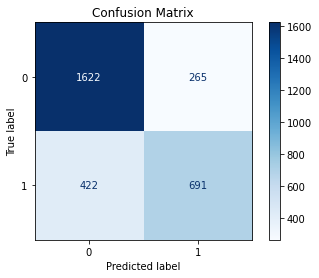

In [38]:
xgboost_random_search(X_train, X_test, y_train, y_test)